In [ ]:
# Install Kaggle library
!pip install kaggle

# Upload your Kaggle API key file (kaggle.json) using the file upload feature in Colab
from google.colab import files

uploaded = files.upload()

# Move the uploaded file to the correct directory
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d artakusuma/basedir

In [2]:
# Unzip the downloaded file
!unzip basedir.zip -d basedir

Streaming output truncated to the last 5000 lines.
  inflating: basedir/base_dir/train_dir/vasc/_124_9140216.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_124_9583724.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_124_9666946.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_124_9892692.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_1184312.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_1215023.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_1458955.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_1545868.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_1749956.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_1897925.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_2100074.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_2213804.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_3130882.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_3398562.jpg  
  inflating: basedir/base_dir/train_dir/vasc/_125_341

In [3]:
!pip install torch torchvision
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import timm

In [5]:
# Check if a GPU is available
device = torch.device("cuda")
#device = torch.device("cpu")
device

device(type='cuda')

In [6]:
from torchvision import transforms

# Define your data transformations
transform = transforms.Compose([
    #transforms.CenterCrop((500, 500)),  # Crop the image at the center
    transforms.Resize((300, 300)),  # Set the desired input size
    transforms.ToTensor(),
])


In [7]:
# Path to the "train" folder containing subfolders with images
data_path = '/content/basedir/base_dir/train_dir'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Calculate the size of the validation set (20% of the total)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
import torch.nn as nn
import torch.optim as optim
import timm

# Initialize the EfficientNet model and move it to the GPU
model_name = 'efficientnet_b0'  # Change to efficientnet_b7
num_classes = len(dataset.classes)

# Load pre-trained EfficientNet model
model = timm.create_model(model_name, pretrained=True)

# Freeze the layers of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),  # Add a fully connected layer with 512 units
    nn.ReLU(),
    nn.Dropout(0.5),  # Add dropout for regularization
    nn.Linear(512, 256),  # Add another fully connected layer with 256 units
    nn.ReLU(),
    nn.Dropout(0.5),  # Add dropout for regularization
    nn.Linear(256, num_classes)  # Output layer with the number of classes
)

model.to(device)

# Define categorical cross-entropy loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())  # You can adjust the weight_decay value


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assuming you have defined your model, criterion, optimizer, train_loader, and val_loader

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in progress_bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = output.max(1)
        total_train += target.size(0)
        correct_train += predicted.eq(target).sum().item()

        progress_bar.set_postfix({'Loss': train_loss / (batch_idx + 1), 'Acc': 100. * correct_train / total_train})

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100. * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = output.max(1)
            total_val += target.size(0)
            correct_val += predicted.eq(target).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Now you can use train_losses, val_losses, train_accuracies, and val_accuracies for plotting learning curves.

Epoch 0: 100%|██████████| 965/965 [04:21<00:00,  3.69batch/s, Loss=0.968, Acc=63]


Epoch 0, Training Loss: 0.9685, Training Accuracy: 62.97%, Validation Loss: 0.6916, Validation Accuracy: 73.85%


Epoch 1: 100%|██████████| 965/965 [04:06<00:00,  3.91batch/s, Loss=0.759, Acc=71.4]


Epoch 1, Training Loss: 0.7595, Training Accuracy: 71.39%, Validation Loss: 0.6113, Validation Accuracy: 77.05%


Epoch 2: 100%|██████████| 965/965 [04:06<00:00,  3.92batch/s, Loss=0.669, Acc=74.5]


Epoch 2, Training Loss: 0.6695, Training Accuracy: 74.50%, Validation Loss: 0.5470, Validation Accuracy: 79.44%


Epoch 3: 100%|██████████| 965/965 [04:05<00:00,  3.92batch/s, Loss=0.614, Acc=76.8]


Epoch 3, Training Loss: 0.6136, Training Accuracy: 76.84%, Validation Loss: 0.5053, Validation Accuracy: 80.97%


Epoch 4: 100%|██████████| 965/965 [04:06<00:00,  3.91batch/s, Loss=0.582, Acc=78.3]


Epoch 4, Training Loss: 0.5819, Training Accuracy: 78.32%, Validation Loss: 0.5082, Validation Accuracy: 80.69%


Epoch 5: 100%|██████████| 965/965 [04:05<00:00,  3.93batch/s, Loss=0.548, Acc=79.4]


Epoch 5, Training Loss: 0.5478, Training Accuracy: 79.44%, Validation Loss: 0.4650, Validation Accuracy: 82.78%


Epoch 6: 100%|██████████| 965/965 [04:06<00:00,  3.92batch/s, Loss=0.525, Acc=80.5]


Epoch 6, Training Loss: 0.5245, Training Accuracy: 80.47%, Validation Loss: 0.4369, Validation Accuracy: 83.83%


Epoch 7: 100%|██████████| 965/965 [04:06<00:00,  3.91batch/s, Loss=0.495, Acc=81.5]


Epoch 7, Training Loss: 0.4951, Training Accuracy: 81.49%, Validation Loss: 0.4334, Validation Accuracy: 84.03%


Epoch 8: 100%|██████████| 965/965 [04:06<00:00,  3.91batch/s, Loss=0.472, Acc=82.8]


Epoch 8, Training Loss: 0.4722, Training Accuracy: 82.76%, Validation Loss: 0.4159, Validation Accuracy: 85.15%


Epoch 9: 100%|██████████| 965/965 [04:05<00:00,  3.94batch/s, Loss=0.451, Acc=83.2]


Epoch 9, Training Loss: 0.4513, Training Accuracy: 83.20%, Validation Loss: 0.4181, Validation Accuracy: 85.23%


Epoch 10: 100%|██████████| 965/965 [04:05<00:00,  3.93batch/s, Loss=0.441, Acc=83.9]


Epoch 10, Training Loss: 0.4414, Training Accuracy: 83.90%, Validation Loss: 0.4173, Validation Accuracy: 84.88%


Epoch 11: 100%|██████████| 965/965 [04:05<00:00,  3.94batch/s, Loss=0.429, Acc=84.2]


Epoch 11, Training Loss: 0.4293, Training Accuracy: 84.22%, Validation Loss: 0.3889, Validation Accuracy: 86.04%


Epoch 12: 100%|██████████| 965/965 [04:05<00:00,  3.93batch/s, Loss=0.42, Acc=84.5]


Epoch 12, Training Loss: 0.4197, Training Accuracy: 84.52%, Validation Loss: 0.3887, Validation Accuracy: 85.65%


Epoch 13: 100%|██████████| 965/965 [04:04<00:00,  3.95batch/s, Loss=0.401, Acc=85.3]


Epoch 13, Training Loss: 0.4005, Training Accuracy: 85.28%, Validation Loss: 0.3737, Validation Accuracy: 86.63%


Epoch 14: 100%|██████████| 965/965 [04:03<00:00,  3.96batch/s, Loss=0.39, Acc=85.6]


Epoch 14, Training Loss: 0.3904, Training Accuracy: 85.62%, Validation Loss: 0.3738, Validation Accuracy: 86.40%


Epoch 15: 100%|██████████| 965/965 [04:03<00:00,  3.96batch/s, Loss=0.385, Acc=85.9]


Epoch 15, Training Loss: 0.3854, Training Accuracy: 85.85%, Validation Loss: 0.3738, Validation Accuracy: 86.48%


Epoch 16: 100%|██████████| 965/965 [04:11<00:00,  3.84batch/s, Loss=0.365, Acc=86.5]


Epoch 16, Training Loss: 0.3645, Training Accuracy: 86.51%, Validation Loss: 0.3561, Validation Accuracy: 87.31%


Epoch 17: 100%|██████████| 965/965 [04:06<00:00,  3.92batch/s, Loss=0.352, Acc=87.3]


Epoch 17, Training Loss: 0.3518, Training Accuracy: 87.25%, Validation Loss: 0.3653, Validation Accuracy: 86.79%


Epoch 18: 100%|██████████| 965/965 [04:05<00:00,  3.94batch/s, Loss=0.356, Acc=87.1]


Epoch 18, Training Loss: 0.3558, Training Accuracy: 87.13%, Validation Loss: 0.3522, Validation Accuracy: 87.23%


Epoch 19: 100%|██████████| 965/965 [04:04<00:00,  3.95batch/s, Loss=0.346, Acc=87.4]


Epoch 19, Training Loss: 0.3461, Training Accuracy: 87.44%, Validation Loss: 0.3468, Validation Accuracy: 88.01%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import timm  # Assuming timm library is installed for EfficientNet

# Assuming there are 23 classes in your skin disease dataset
resnet_num_classes = 23

# Initialize the ResNet18 model and move it to the GPU
resnet_model = models.resnet18(pretrained=True)

# Freeze the pre-trained weights
for param in resnet_model.parameters():
    param.requires_grad = False

# Get the number of input features for the fully connected layer in ResNet18
num_features_resnet = resnet_model.fc.in_features

# Define additional layers for ResNet18
additional_layers_resnet = nn.Sequential(
    nn.Linear(num_features_resnet, 512),  # Add a fully connected layer with 512 neurons
    nn.BatchNorm1d(512),                  # Add batch normalization
    nn.ReLU(inplace=True),                # Add ReLU activation function
    nn.Dropout(0.5),                       # Add dropout for regularization
    nn.Linear(512, 256),                  # Add another fully connected layer with 256 neurons
    nn.BatchNorm1d(256),                  # Add batch normalization
    nn.ReLU(inplace=True),                # Add ReLU activation function
    nn.Dropout(0.5)                       # Add dropout for regularization
)

# Modify the classifier of ResNet18 to include the additional layers
resnet_model.fc = additional_layers_resnet

# Initialize the EfficientNet-B0 model and move it to the GPU
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# Freeze the pre-trained weights
for param in efficientnet_model.parameters():
    param.requires_grad = False

# Get the number of input features for the fully connected layer in EfficientNet-B0
num_features_efficientnet = efficientnet_model.classifier.in_features

# Define additional layers for EfficientNet-B0
additional_layers_efficientnet = nn.Sequential(
    nn.Linear(num_features_efficientnet, 512),  # Add a fully connected layer with 512 neurons
    nn.BatchNorm1d(512),                        # Add batch normalization
    nn.ReLU(inplace=True),                     # Add ReLU activation function
    nn.Dropout(0.5)                             # Add dropout for regularization
)

# Modify the classifier of EfficientNet-B0 to include the additional layers
efficientnet_model.classifier = additional_layers_efficientnet

# Define the classifier for the combined features
combined_classifier = nn.Sequential(
    nn.Linear(768, 256),  # Updated input size to match the combined features
    nn.BatchNorm1d(256),   # Add batch normalization
    nn.ReLU(inplace=True), # Add ReLU activation function
    nn.Dropout(0.5),       # Add dropout for regularization
    nn.Linear(256, resnet_num_classes)  # Add a fully connected layer for the output
)

# Define the final model by combining the ResNet18 and EfficientNet-B0 branches with the classifier
class PretrainedCombinedModel(nn.Module):
    def __init__(self, resnet_model, efficientnet_model, combined_classifier):
        super(PretrainedCombinedModel, self).__init__()
        self.resnet_model = resnet_model
        self.efficientnet_model = efficientnet_model
        self.combined_classifier = combined_classifier

    def forward(self, x):
        resnet_features = self.resnet_model(x)
        efficientnet_features = self.efficientnet_model(x)
        combined_features = torch.cat((resnet_features, efficientnet_features), dim=1)  # Concatenate the features from both models
        output = self.combined_classifier(combined_features)
        return output

# Create an instance of the combined model
model = PretrainedCombinedModel(resnet_model, efficientnet_model, combined_classifier)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

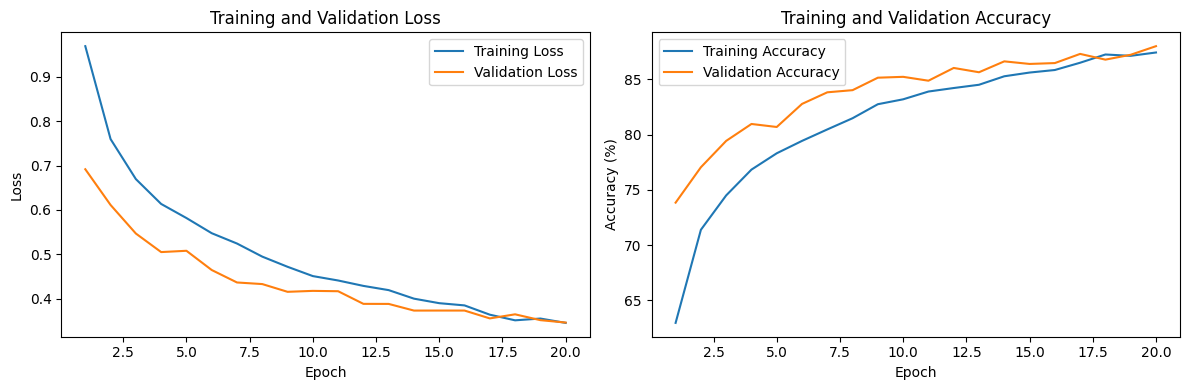

In [10]:
import matplotlib.pyplot as plt

# Assuming you have train_losses, val_losses, train_accuracies, and val_accuracies from your training loop

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Path to the "test" folder containing subfolders with images
test_data_path = '/content/basedir/base_dir/val_dir'

# Load the test dataset using ImageFolder
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

# Define data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Evaluate on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = output.max(1)
        test_total += target.size(0)
        test_correct += predicted.eq(target).sum().item()

test_accuracy = (test_correct / test_total) * 100
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 90.08528784648188%


In [12]:
import os

# Define path to the train folder
train_folder = "/content/basedir/base_dir/train_dir"

# Iterate through subfolders
for subfolder in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder)

    # Count the number of images in the subfolder
    num_images = len(os.listdir(subfolder_path))

    print(f"Subfolder '{subfolder}' contains {num_images} images.")


Subfolder 'nv' contains 5954 images.
Subfolder 'df' contains 4410 images.
Subfolder 'mel' contains 5920 images.
Subfolder 'akiec' contains 5217 images.
Subfolder 'vasc' contains 5290 images.
Subfolder 'bcc' contains 5858 images.
Subfolder 'bkl' contains 5920 images.


In [13]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
model.eval()

# Turn off gradients for evaluation
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        _, predicted = output.max(1)

        # Store true labels and predicted labels
        true_labels.extend(target.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


F1 Score: 0.8929643482773525
Confusion Matrix:
[[ 11   4   5   0   4   2   0]
 [  3  24   2   0   0   1   0]
 [  3   0  56   0   3  13   0]
 [  1   0   1   0   0   3   1]
 [  3   2   9   0  13  12   0]
 [  0   2   8   0   3 734   4]
 [  0   0   0   0   0   4   7]]


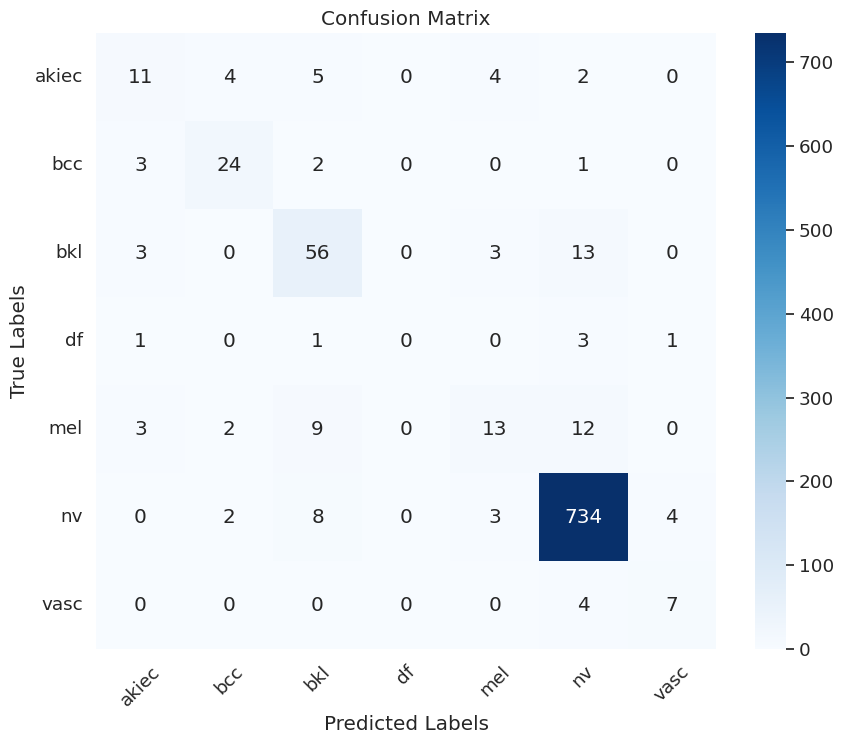

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define classes based on the dataset
classes = test_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
